In [1]:
import numpy as np
import sys
import time
import h5py as h5
import matplotlib.pyplot as plt

sys.path.append(r"C:\Users\haoyuan\Documents\GitHub\CrystalDiff")

from CrystalDiff import util, pulse, lclsutil, groutine, crystal

# Get the Crystal Geometries

In [2]:
# ----------------------------------------------------------------------------------------------------------
#                       Step 1: Pulse
# ----------------------------------------------------------------------------------------------------------

energy_center = 10.
pre_length = 1e6

# Set up the pulse
my_pulse = pulse.GaussianPulse3D()
my_pulse.set_pulse_properties(central_energy=energy_center,
                              polar=[0., 1., 0.],
                              sigma_x=708.2581446128465,
                              sigma_y=708.2581446128465,
                              sigma_z=100.,
                              x0=np.array([0., 0., -pre_length]))

# ----------------------------------------------------------------------------------------------------------
#                       Step 3: Delay Lines
# ----------------------------------------------------------------------------------------------------------
dtheta = 0.

# Some meta data for the delay line.
reflect_num = 4
h_length = 2. * np.pi / (1.9201 * 1e-4)
hlen_vals = np.array([h_length, ] * reflect_num)

# Some crystal properties
chi0=complex(-0.97631E-05, 0.14871E-06)
chih_sigma=complex(0.59310E-05, -0.14320E-06)
chihbar_sigma=complex(0.59310E-05, -0.14320E-06)
chih_pi=complex(0.46945E-05, -0.11201E-06)
chihbar_pi=complex(0.46945E-05, -0.11201E-06)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                       Crystal for branch  1
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Set up the angles
angle_offset_1 = dtheta
bragg_angle_1 = np.radians(18.836) + 13e-6

branch_angle_1 = lclsutil.get_delay_line_angles(angle_offset=angle_offset_1,
                                                theta=bragg_angle_1 + np.pi / 2. ,
                                                rho=bragg_angle_1 - np.pi / 2. ,
                                                inclined_angle=np.radians(10.))
surface_points_1 = np.zeros((reflect_num, 3), dtype=np.float64)

# Set the misalignment angle
misalign_branch_1_crystal_1 = [0., 0., 0.]
misalign_branch_1_crystal_2 = [0., 0., 0.]

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_1[0],
                                                        rho_vals=branch_angle_1[1],
                                                        tau_vals=branch_angle_1[2],
                                                        surface_points=surface_points_1,
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi,
                                                        misalign_1=misalign_branch_1_crystal_1,
                                                        misalign_2=misalign_branch_1_crystal_2)

path_list_1 = [0, 1e5, 1e5, 1e5]
post_distance = 1e6

# Arrange the crystals

In [3]:
# Get the positions for the shearing fix branch
(intersect_branch_1,
kout_branch_1) = lclsutil.get_point_with_definite_path(kin_vec = my_pulse.k0,
                                                       path_sections = path_list_1,
                                                       crystal_list = crystal_list_1)

# Initialize the crystals
crystal_list_1 = lclsutil.get_crystal_list_delay_branch(hlen_vals=hlen_vals,
                                                        theta_vals=branch_angle_1[0],
                                                        rho_vals=branch_angle_1[1],
                                                        tau_vals=branch_angle_1[2],
                                                        surface_points=np.copy(intersect_branch_1),
                                                        chi0=chi0,
                                                        chih_sigma=chih_sigma, chihbar_sigma=chihbar_sigma,
                                                        chih_pi=chih_pi, chihbar_pi=chihbar_pi,
                                                        misalign_1=misalign_branch_1_crystal_1,
                                                        misalign_2=misalign_branch_1_crystal_2)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the observation point
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
observation = np.copy(intersect_branch_1[-1]) + post_distance * kout_branch_1[-1] / util.l2_norm(kout_branch_1[-1]) 
total_path = pre_length + util.get_total_path_length(intersect_branch_1) + post_distance

print("The total propagation length is {:.2f}m.".format(total_path / 1e6))


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Change frame
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# 
(my_pulse,
 crystal_list_1,
 observation
) = lclsutil.get_delay_line_output_frame(displacement=-np.copy(observation),
                                         observe=observation,
                                         pulse=my_pulse,
                                         crystal_list=crystal_list_1)

# 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#                  Get the momentum mesh
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
number_x = 2
number_y = 250
number_z = 10 ** 5
kx_grid, ky_grid, kz_grid, axis_info = lclsutil.get_k_mesh_3d(number_x=number_x,
                                                              number_y=number_y,
                                                              number_z=number_z,
                                                              delta_e_x=1e-50,
                                                              delta_e_y=0.75e-4,
                                                              delta_e_z=4e-4 / util.c)
kz_grid += my_pulse.klen0

# Apply fft shift
# kx_grid = np.ascontiguousarray(np.fft.fftshift(kx_grid))
kx_grid = np.zeros(1, np.float64)
number_x = 1
ky_grid = np.zeros(1, np.float64)
number_y = 1
kz_grid = np.ascontiguousarray(np.fft.fftshift(kz_grid))
#"""

The total propagation length is 2.30m.


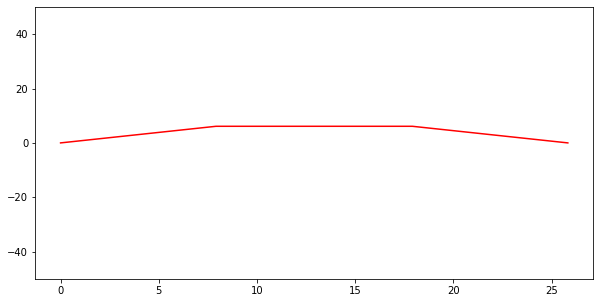

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

axes.plot(intersect_branch_1[:,2]/1e4, intersect_branch_1[:,1]/1e4,'r')

#axes.set_xlim([5e2-70, 5e2 + 150])
axes.set_ylim([-50, 50])
#axes.set_aspect('equal', 'datalim')

plt.show()

In [5]:
# Set the range of the index to save
z_idx_range = number_z
num1 = number_z
num2 = 0
d_num = 512

# -------------------------------------------------------------
#            Get Field for Branch 2
# -------------------------------------------------------------
tic = time.time()

(result_3d_dict_1,
 result_2d_dict_1,
 check_dict_1) = groutine.get_delay_line_field(channel_cuts = crystal_list_1,
                                               total_path = total_path, 
                                               observation = observation,
                                               my_pulse = my_pulse,
                                               kx_grid = kx_grid,
                                               ky_grid = ky_grid,
                                               kz_grid = kz_grid,
                                               pulse_delay_time = 0.,
                                               pulse_k0_final = np.array([0.,0.,my_pulse.klen0]),
                                               number_x = number_x,
                                               number_y = number_y,
                                               number_z = number_z,
                                               z_idx_range = z_idx_range,
                                               num1 = num1,
                                               num2 = num2, 
                                               d_num = 512)

toc = time.time()
print("It takes {:.2f} seconds to get the field for branch 1.".format(toc - tic))

It takes 0.04 seconds to prepare the variables.
It takes 0.35 seconds to get the field for branch 1.


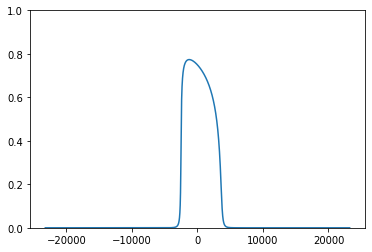

In [6]:
plt.plot(axis_info['z_idx'], np.abs(np.fft.fftshift(check_dict_1['reflectivity_pi_tot'] ** 2)))
plt.ylim([0,1])
plt.show()

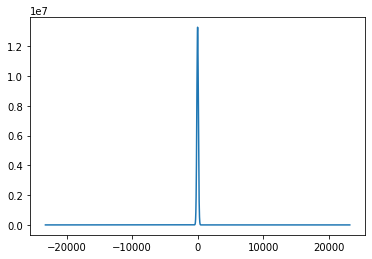

In [7]:
plt.plot(axis_info['z_idx'], np.abs(np.fft.fftshift(check_dict_1['scalar_spec'])))
plt.show()

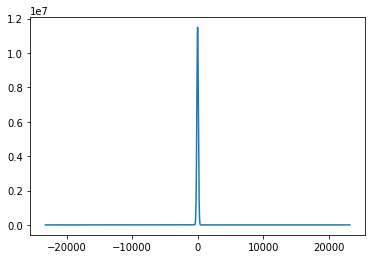

In [8]:
plt.plot(axis_info['z_idx'], np.fft.fftshift(np.abs(result_3d_dict_1['efield_spec_3d'][0,0,:,1])))
plt.show()

In [11]:
np.sum(np.square(np.abs(check_dict_1['coef_grid']))) / np.sum(np.square(np.abs(check_dict_1['scalar_spec'])))

1.0000000000261797

In [13]:
np.sum(np.square(np.abs(result_2d_dict_1['y_spec_2d']))) / np.sum(np.square(np.abs(check_dict_1['coef_grid'])))

0.7490749337754868

In [ ]:
plt.plot(axis_info['z_idx'], np.fft.fftshift(np.abs(check_dict_1['jacob_grid'])))
plt.show()